# CAMDA
https://bipress.boku.ac.at/camda2025/the-camda-contest-challenges/#synthetic-health-records

The Synthetic Clinical Health Records Challenge provides a rich set of highly realistic Electronic Health Records (EHRs) tracing the diagnosis trajectories of diabetic patients, created with dual-adversarial auto-encoders trained on data from 1.2 million real patients in the Population Health Database of the Andalusian Ministry of Health. Predict relevant diabetes endpoints like blindness or cardiopathy from past diagnosis trajectories!

`DATASET DESCRIPTION: 
DualAAE-EHR DIABETES GEN3 for CAMDA (diabetes-dualAAE-EHR-CAMDA GEN`3):

A 3rd generation synthetic dataset was generated by the same DualAA -EHR
model from an extended population of 1062550 real diabetes pat  ents.

The cohort of real patients has some differences in filterng and 
preprocessing regading previous generations   mainly:

- Amputation, a low frequency endpoint, is kept for all visits, not filtering.
- Sex is still coded as a first visit with the following labels:
  "1111" --> men | "2222" --> women
- All visits feature an age label. Ages from 0-120 are labelled as:
  "9000", "9001", "9002", ..., "9120"
- Chronic pathology codes have been reduced to 81. Two codes were removed 
  from previous generation (not considered chronic anymore):
  "0901" -> Acute cerebrovascular disease
  "0903" -> Transient ischemic attack

The 999,936 patients for this third generation synthetic EHRs were generated
extended visit dates and new patients till end of 2022. Each patient is still 
coded as a ordered list of visits, each of them with a list of co-occurring 
chronic diagnoses. As the diagnoses are chronic they all affect patients from
the time recorded onwards.  

A pre-processed cleaned up version of this dataset is also provided, in
case users want to use it instead: daae_generated_diabetes_patients_camda_gen3_preprocessed.json  

This pre-processed version reduces the number of patients to 994,095 by
performing the following cleaning steps:
- Patients without diabetes code were discarded.
- Empty visits or visits only with age codes were removed.
- Only the first appearance of each diagnosis was kept (as they are
  chronic diseases).
- In case several age codes are provided in one visit, the code of the
  older age is kept.
- In visits without age code, age is inferred. Average age between previous
  and posterior visit is considered. In case visit is the first or last one, 
  same age as posterior or previous visit is considered, respectively.

Two challenges are suggested on both datasets, although any other original analysis you may think will also be welcomed:

1) Finding some strong relationships in diabetes-associated pathologies that allows to predict any pathology before this is diagnosed. Some well-known pathological diabetes consequences, which can be considered relevant endpoints to predict, can be:  
   a) Retinopathy (Code “703”),  
   b) Chronic kidney disease (Code “1401”),  
   c) Ischemic heart disease (Code “910”),  
   d) Amputations (Code “1999”)  

2) Another proposed challenge is the prediction of disease trajectories in diabetes patients (see for example: Jensen et al. Nat Commun. 2014)

Prediction proposals which are submitted with the model trained and the code required to run the model can be tested on the real dataset by the organisers and participate in a collective publication.

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#format data
with open('data/daae_generated_diabetes_patients_camda_gen3_preprocessed.json', 'r') as file:
    data = json.load(file)
rows=[]
for k,v in data.items():
    #print(v.pop(0),v)
    if len(v[0]) == 1:
        row = {"id":k,"sex":v.pop(0)[0],"relation":v}
        rows.append(row)
    else:
        row = {"id":k,"sex":"NA","relation":v}
        rows.append(row)

In [ ]:
data = pd.DataFrame(rows)

In [ ]:
data["number of visit"] = data["relation"].apply(len)

In [ ]:
data.shape

In [ ]:
data2 = data[((data["sex"] == '1111') | (data["sex"] == '2222')  | (data["sex"] == 'NA'))] #datapoints with no age or sex 0.3%

In [ ]:
data2.shape

In [ ]:
sns.histplot(data2["number of visit"], color='orange')
plt.title('Distribution of number of visits')
plt.xlabel("Number of visits")
plt.ylabel('Frequency')

In [ ]:
data2.shape

In [ ]:
data2 = data2[data2["number of visit"]!=1] #filtering entries with one visit only 12.5%

In [ ]:
data2.shape

In [ ]:
data2[data2["sex"]=="NA"] #5.2% without gender

In [ ]:
sex_counts = data2['sex'].value_counts()
plt.bar(sex_counts.index, sex_counts.values)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Sex Distribution')
plt.show()

----------------------------------------------

In [ ]:
def process(i):
    return i[0]

In [ ]:
data2["first_visit"] = data2["relation"].apply(process)

In [ ]:
data2

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, to_hex
import matplotlib.colors as mcolors
import random

In [27]:
plt.style.use('default')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['figure.facecolor'] = 'lightgray'
plt.rcParams['axes.facecolor'] = 'lightgray'

In [28]:
diabetes_df = pd.read_csv('results/Traj_diabetes.csv')
all_direct = diabetes_df.groupby('d2.name')['r1.overall_frequency'].sum().sort_values(ascending=False)
all_direct_diseases = all_direct.index.tolist()

In [29]:
# Create a list of random colors for nodes
def generate_random_colors(n):
    colors = []
    for _ in range(n):
        # Generate random but reasonably bright colors
        r = random.uniform(0.4, 0.9)
        g = random.uniform(0.4, 0.9)
        b = random.uniform(0.4, 0.9)
        colors.append((r, g, b))
    return colors

# Process each disease and create separate plots
for i, disease in enumerate(all_direct_diseases):
    # Filter data for this specific disease trajectory
    disease_data = diabetes_df[diabetes_df['d2.name'] == disease]
    
    # Get subsequent diseases for this primary disease
    subsequent_diseases = disease_data.nlargest(10, 'r2.overall_frequency')
    
    # Skip if no subsequent diseases
    if len(subsequent_diseases) == 0:
        continue
        
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes with attributes
    G.add_node('Diabetes', type='source', size=3000)
    G.add_node(disease, type='primary', size=2000)
    
    # Add edges from Diabetes to primary disease
    primary_freq = disease_data['r1.overall_frequency'].iloc[0]
    primary_time = disease_data['r1.overall_avg_years'].iloc[0]
    G.add_edge('Diabetes', disease, weight=1, time=primary_time)
    
    # Add subsequent diseases and edges
    for _, row in subsequent_diseases.iterrows():
        subsequent_disease = row['d3.name']
        freq = row['r2.overall_frequency']
        time = row['r2.overall_avg_years']
        
        G.add_node(subsequent_disease, type='subsequent', size=1500)
        G.add_edge(disease, subsequent_disease, weight=1, time=time)
    
    # Define node positions manually for better layout
    pos = {}
    pos['Diabetes'] = np.array([0.5, 1])
    pos[disease] = np.array([0.5, 0.5])
    
    # Position subsequent diseases in a semicircle
    subsequent_nodes = [n for n in G.nodes() if n != 'Diabetes' and n != disease]
    num_subsequent = len(subsequent_nodes)
    
    for j, node in enumerate(subsequent_nodes):
        angle = np.pi * (j / (num_subsequent - 1) if num_subsequent > 1 else 0.5)
        x = 0.5 + 0.4 * np.cos(angle)
        y = 0.1 + 0.2 * np.sin(angle)
        pos[node] = np.array([x, y])
    
    # Assign fixed colors to Diabetes and primary disease, random to others
    node_colors = {}
    for node in G.nodes():
        if node == 'Diabetes':
            node_colors[node] = (0.7, 0.85, 1.0)  # Light blue
        elif node == disease:
            node_colors[node] = (1.0, 1.0, 0.8)   # Light yellow
        else:
            # Generate random color for subsequent nodes
            r = random.uniform(0.4, 0.9)
            g = random.uniform(0.4, 0.9)
            b = random.uniform(0.4, 0.9)
            node_colors[node] = (r, g, b)
    
    # Get edge times for coloring
    edge_times = [G[u][v]['time'] for u, v in G.edges()]
    time_vmin = min(edge_times) if edge_times else 0
    time_vmax = max(edge_times) if edge_times else 1
    
    # Create a colormap for edges based on transition time (yellow to red)
    edge_cmap = LinearSegmentedColormap.from_list('yellow_to_red', ['red', 'orange', 'yellow'])
    
    # Create a new figure for this disease with gray background
    fig, ax = plt.subplots(figsize=(12, 10), facecolor='lightgray')
    ax.set_facecolor('lightgray')
    
    # Draw edges with color based on time (constant thickness)
    edge_colors = [edge_cmap((t - time_vmin) / (time_vmax - time_vmin)) 
                  if time_vmax > time_vmin else edge_cmap(0.5) for t in edge_times]
    
    edges = nx.draw_networkx_edges(
        G, pos, 
        width=1,  # Constant thickness
        edge_color=edge_colors,
        alpha=0.8,
        ax=ax,
        arrows=True,
        arrowsize=20,
        arrowstyle='->',
        connectionstyle='arc3,rad=0.1'
    )
    
    # Draw nodes with fixed colors for Diabetes and primary, random for others, and no borders
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=[node_colors[node] for node in G.nodes()],
        node_size=[G.nodes[node]['size'] for node in G.nodes()],
        alpha=0.9,
        ax=ax,
        edgecolors=None,  # No border
        linewidths=0
    )
    
    # Draw labels with subtle styling (not bold)
    labels = {}
    for node in G.nodes():
        if node == 'Diabetes':
            labels[node] = 'Diabetes'
        else:
            # Shorten long disease names for better display
            if len(node) > 20:
                labels[node] = node[:17] + '...'
            else:
                labels[node] = node
    
    # Draw node labels with regular font (not bold)
    nx.draw_networkx_labels(G, pos, labels, font_size=9, ax=ax, 
                           font_color='black', alpha=0.9, font_weight='normal')
    
    # Set title with frequency information
    ax.set_title(f'Diabetes Disease Trajectory: Diabetes → {disease}\n(n={primary_freq:,})', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.1)
    ax.axis('off')
    
    # Add a colorbar for edge transition times
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = mcolors.Normalize(vmin=time_vmin, vmax=time_vmax)
    sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Transition Time (Years)', fontsize=12)
    
    # Add text box with summary information in top left corner
    summary_text = f"Primary transition: {primary_time:.1f} years\n\nSubsequent transitions:"
    for _, row in subsequent_diseases.iterrows():
        summary_text += f"\n- {row['d3.name']}: {row['r2.overall_avg_years']:.1f} years (n={row['r2.overall_frequency']:,})"
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black')
    ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', bbox=props)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    filename = f"diabetes_trajectory_{disease.replace(' ', '_').replace('/', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='lightgray')
    plt.close()
    
    print(f"Created visualization for Diabetes → {disease}")

# Print summary information
print("\nAll diseases directly following Diabetes:")
for i, (disease, freq) in enumerate(all_direct.items(), 1):
    print(f"{i}. {disease}: {freq:,} cases")

C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Hyperlipidaemia


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Hypertension


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Arthrosis/spondylosis


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Anxiety disorder


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Obesity


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → COPD


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Heart failure


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Tobacco dependence


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Ischemic heart disease


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Hypothyroidism


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Retinopathy


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Atrial fibrillation


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Chronic kidney disease


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Mood disorder


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Glaucoma


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Asthma


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Extremity arteriopathy diseases


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Motor disorders with no CVA


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Osteoporosis


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Other arthropathies


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Urinary lithiasis


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Psoriasis


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Alcohol dependence


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Dementia


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Other organic mental disorder


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Hepatic steatosis


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Gout and other crystal deposition diseases


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Gastroesophageal reflux disease


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Acquired heart diseases


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Ischemic hepatitis except for cirrhosis


C:\Users\shasa\AppData\Local\Temp\ipykernel_24452\1938533617.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Created visualization for Diabetes → Age-related macular degeneration

All diseases directly following Diabetes:
1. Hyperlipidaemia: 6,900,420 cases
2. Hypertension: 6,820,230 cases
3. Arthrosis/spondylosis: 1,299,172 cases
4. Anxiety disorder: 915,460 cases
5. Obesity: 387,468 cases
6. COPD: 283,778 cases
7. Heart failure: 198,211 cases
8. Tobacco dependence: 169,117 cases
9. Ischemic heart disease: 168,210 cases
10. Hypothyroidism: 154,913 cases
11. Retinopathy: 137,896 cases
12. Atrial fibrillation: 137,322 cases
13. Chronic kidney disease: 72,028 cases
14. Mood disorder: 68,944 cases
15. Glaucoma: 42,060 cases
16. Asthma: 35,390 cases
17. Extremity arteriopathy diseases: 30,366 cases
18. Motor disorders with no CVA: 19,180 cases
19. Osteoporosis: 15,306 cases
20. Other arthropathies: 15,288 cases
21. Urinary lithiasis: 15,240 cases
22. Psoriasis: 14,094 cases
23. Alcohol dependence: 12,744 cases
24. Dementia: 10,299 cases
25. Other organic mental disorder: 8,745 cases
26. Hepatic s

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [31]:
plt.style.use('default')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1

In [32]:
diabetes_df = pd.read_csv('results/Traj_diabetes.csv')
top_direct = diabetes_df.groupby('d2.name')['r1.overall_frequency'].sum().nlargest(10)
top_direct_diseases = top_direct.index.tolist()

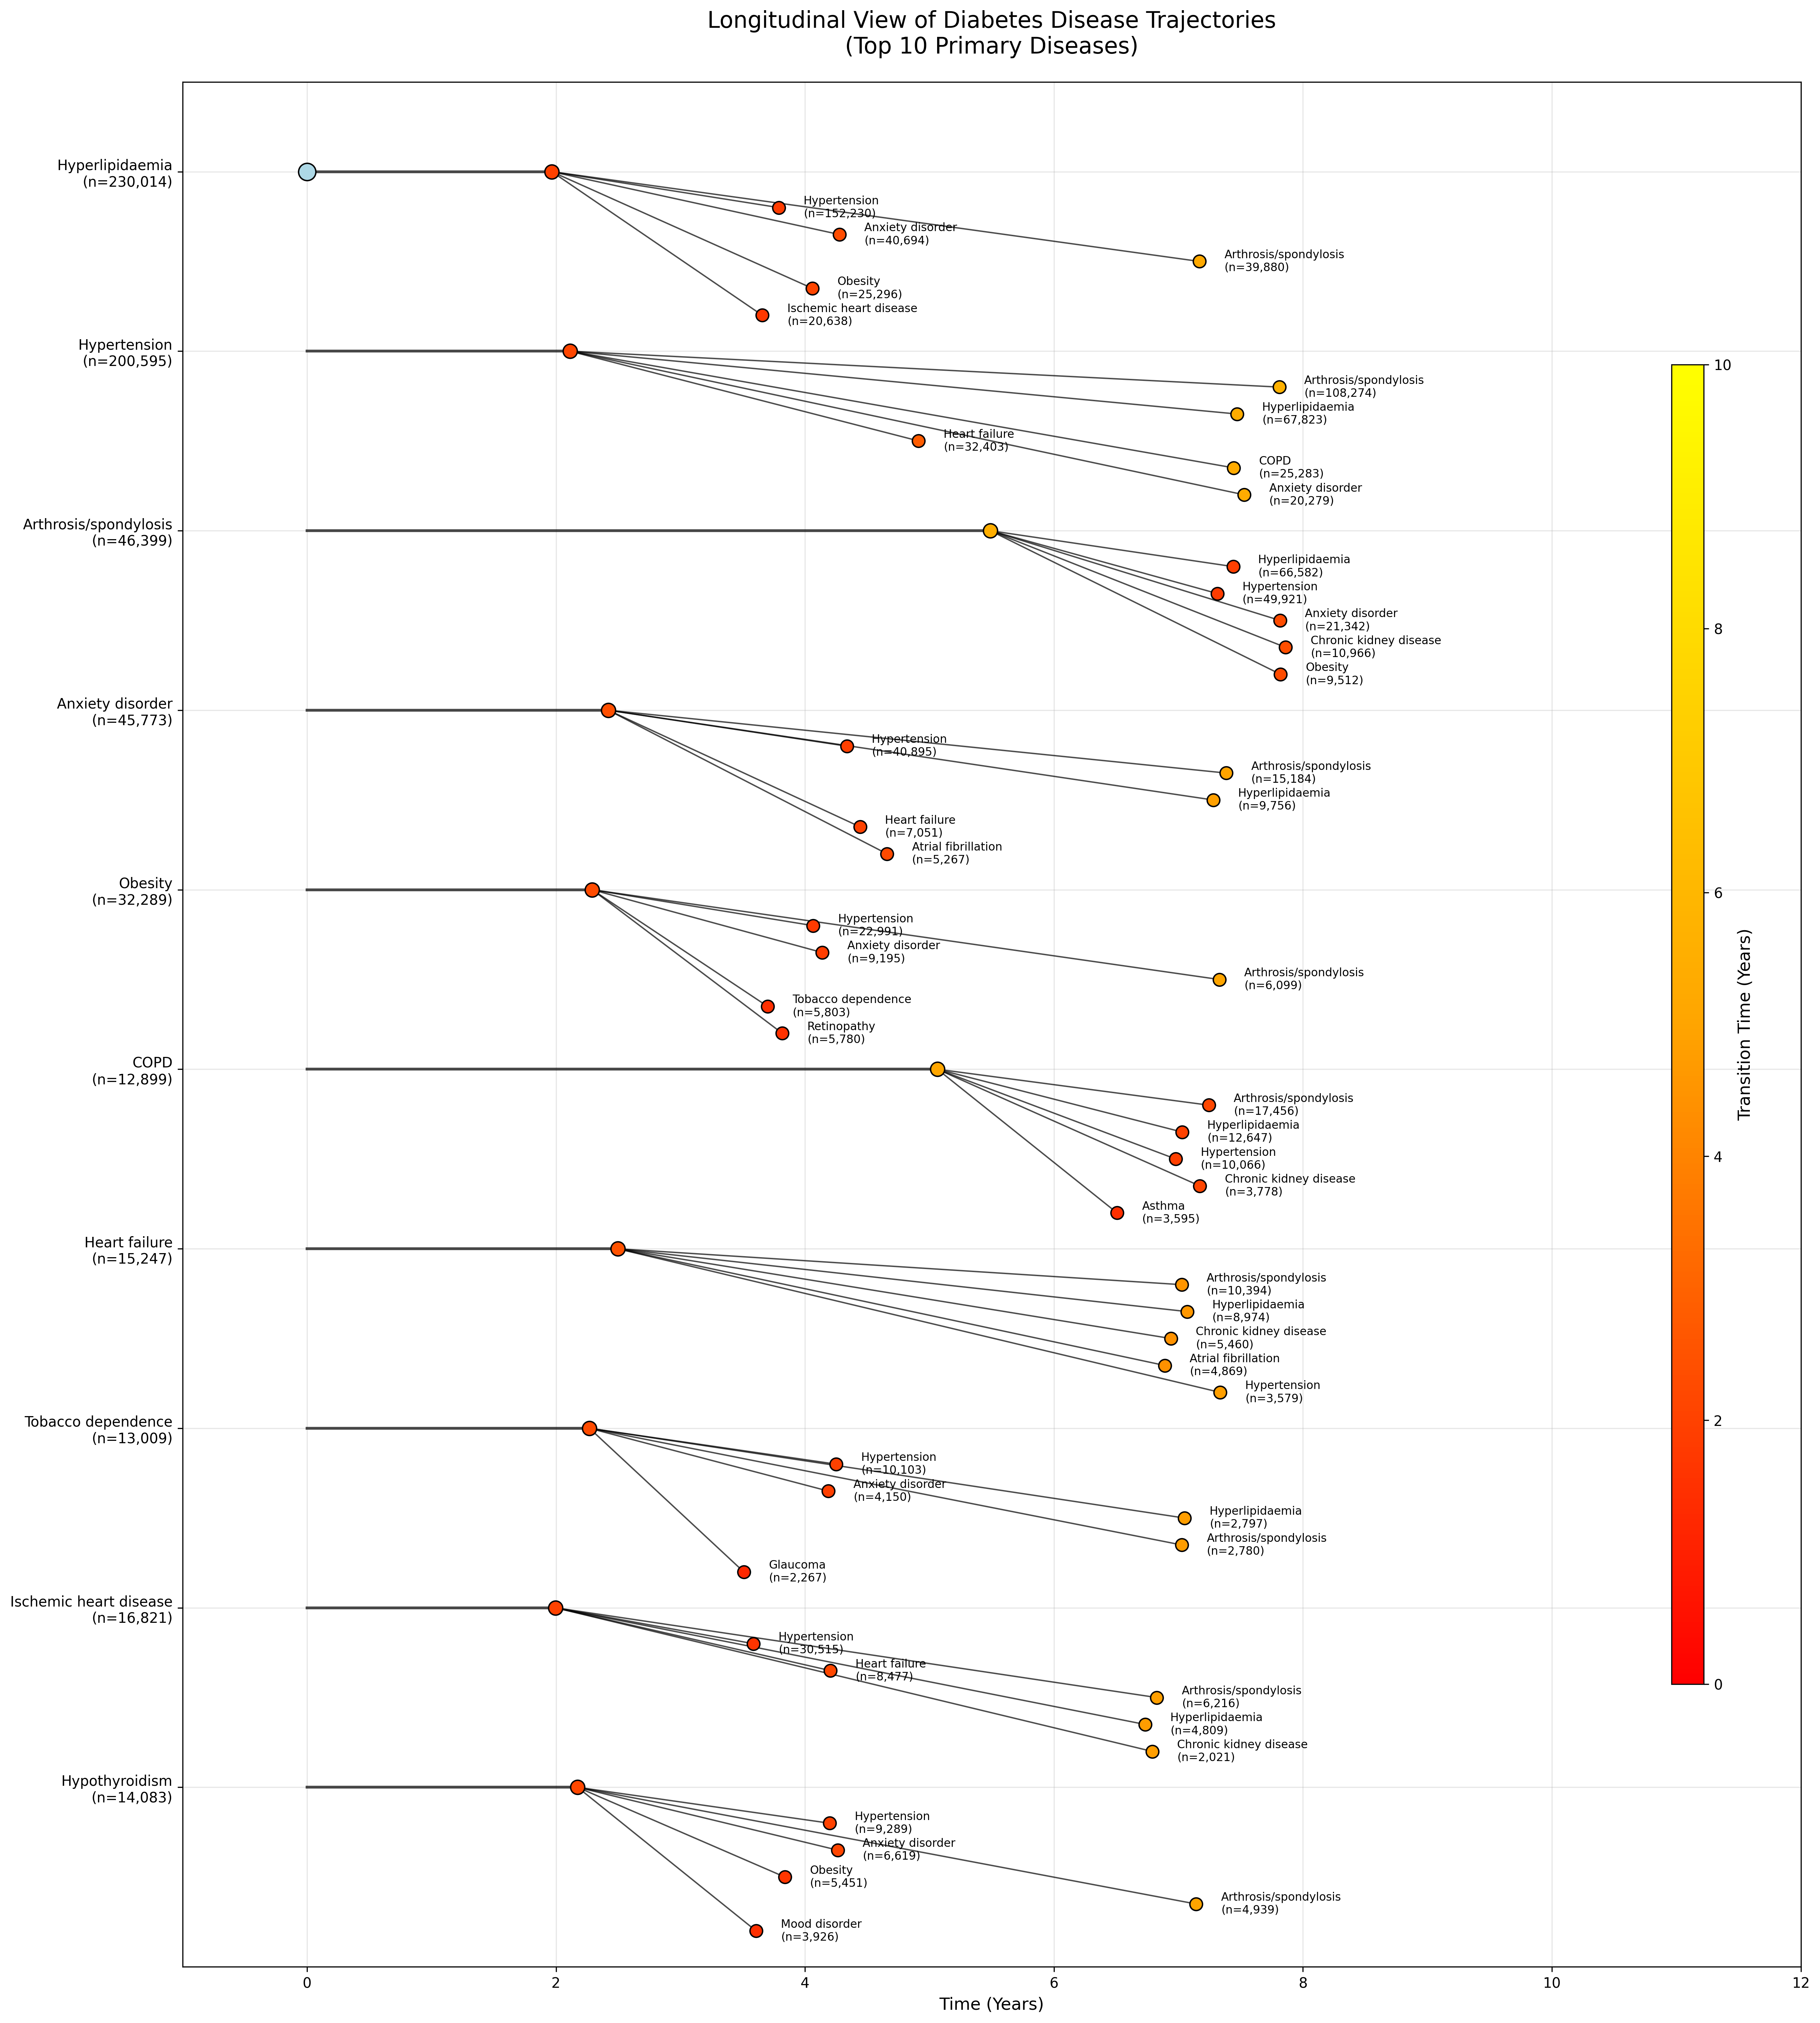

In [35]:
time_cmap = LinearSegmentedColormap.from_list('yellow_to_red', ['red', 'orange', 'yellow'])

plt.figure(figsize=(18, 20))

y_pos = 0
yticks = []
yticklabels = []

for i, disease in enumerate(top_direct_diseases):
    disease_data = diabetes_df[diabetes_df['d2.name'] == disease]
    primary_time = disease_data['r1.overall_avg_years'].iloc[0]
    primary_freq = disease_data['r1.overall_frequency'].iloc[0]
    
    # Get top 5 subsequent diseases
    subsequent_diseases = disease_data.nlargest(5, 'r2.overall_frequency')
    
    # Plot primary disease
    yticks.append(y_pos)
    yticklabels.append(f"{disease}\n(n={primary_freq:,})")
    
    # Draw line from Diabetes to primary disease
    plt.plot([0, primary_time], [y_pos, y_pos], 'k-', linewidth=2, alpha=0.7)
    plt.scatter(primary_time, y_pos, s=100, c=primary_time, cmap=time_cmap, 
                vmin=0, vmax=10, edgecolors='black', zorder=5)
    
    # Plot subsequent diseases
    for j, (_, row) in enumerate(subsequent_diseases.iterrows()):
        subsequent_time = row['r2.overall_avg_years']
        subsequent_freq = row['r2.overall_frequency']
        
        # Draw line from primary to subsequent disease
        plt.plot([primary_time, primary_time + subsequent_time], 
                 [y_pos, y_pos - 0.2 - j*0.15], 'k-', linewidth=1, alpha=0.7)
        
        # Plot subsequent disease point
        plt.scatter(primary_time + subsequent_time, y_pos - 0.2 - j*0.15, 
                   s=80, c=subsequent_time, cmap=time_cmap, 
                   vmin=0, vmax=10, edgecolors='black', zorder=5)
        
        # Add label for subsequent disease
        plt.text(primary_time + subsequent_time + 0.2, y_pos - 0.2 - j*0.15, 
                f"{row['d3.name']}\n(n={subsequent_freq:,})", 
                fontsize=8, va='center')
    
    y_pos -= 1

# Add Diabetes at time 0
plt.scatter(0, 0, s=150, c='lightblue', edgecolors='black', zorder=5)
plt.text(-0.5, 0, '', fontsize=12, ha='right', va='center', weight='bold')

# Format the plot
plt.yticks(yticks, yticklabels)
plt.xlabel('Time (Years)')
plt.title('Longitudinal View of Diabetes Disease Trajectories\n(Top 10 Primary Diseases)', fontsize=16, pad=20)
plt.grid(True, alpha=0.3)
plt.xlim(-1, 12)
plt.ylim(y_pos + 0.0001, 0.5)

# Add colorbar
cbar_ax = plt.gca().inset_axes([0.92, 0.15, 0.02, 0.7])
norm = mcolors.Normalize(vmin=0, vmax=10)
sm = plt.cm.ScalarMappable(cmap=time_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Transition Time (Years)', fontsize=12)

plt.tight_layout()
plt.savefig('diabetes_longitudinal_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import os
from langchain_ollama import OllamaLLM
from langchain_community.graphs import Neo4jGraph
from langchain.chains import GraphCypherQAChain

NEO4J_URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME", "neo4j")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "CAMDA@123121")

OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")
OLLAMA_MODEL = os.getenv("OLLAMA_MODEL", "deepseek-r1:8b") #llama3.1:latest deepseek-r1:8b phi3:latest

llm = OllamaLLM(base_url=OLLAMA_BASE_URL,model=OLLAMA_MODEL)

graph=Neo4jGraph(url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD)

graph.refresh_schema()
print(graph.schema)

In [ ]:
chain=GraphCypherQAChain.from_llm(llm=llm,graph=graph,verbose=True,allow_dangerous_requests=True)

In [ ]:
response=chain.invoke({"query":"I am diagnosed with Diabetes (name). What are the complications I might be susceptible to in 2 years time? "})
response

In [25]:
import os
import re
from langchain_ollama import OllamaLLM
from langchain_community.graphs import Neo4jGraph
from langchain.prompts import ChatPromptTemplate
from langchain.schema import HumanMessage, SystemMessage
from typing import List, Dict, Any

NEO4J_URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME", "neo4j")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "CAMDA@123121")
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")
OLLAMA_MODEL = os.getenv("OLLAMA_MODEL", "llama3.1:latest")

# Initialize components
print("Initializing LLM and Graph connections...")
llm = OllamaLLM(base_url=OLLAMA_BASE_URL, model=OLLAMA_MODEL)
graph = Neo4jGraph(url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD)
print("LLM and Graph initialized successfully\n")

class MedicalQueryProcessor:
    def __init__(self, graph: Neo4jGraph, llm: OllamaLLM):
        self.graph = graph
        self.llm = llm
        self.diagnosis_cache = {}
        
    def get_diagnosis_id(self, diagnosis_name: str) -> str:
        """Get diagnosis code from name with caching"""
        print(f"Looking up diagnosis: '{diagnosis_name}'")
        if diagnosis_name in self.diagnosis_cache:
            print(f"Found in cache: {self.diagnosis_cache[diagnosis_name]}")
            return self.diagnosis_cache[diagnosis_name]
        query = """
        MATCH (d:Diagnosis) 
        WHERE toLower(d.name) CONTAINS toLower($name) OR toLower(d.code) CONTAINS toLower($name)
        RETURN d.code as code, d.name as name
        LIMIT 5
        """
        print("Executing diagnosis lookup query...")
        result = self.graph.query(query, params={"name": diagnosis_name})
        print(f"Query returned {len(result)} results")        
        if result and len(result) > 0:
            for i, res in enumerate(result):
                print(f"Result {i+1}: {res['code']} - {res['name']}")
            self.diagnosis_cache[diagnosis_name] = result[0]['code']
            print(f"Selected diagnosis code: {result[0]['code']}")
            return result[0]['code']
        print("No diagnosis found")
        return None
    
    def get_complications_within_timeframe(self, diagnosis_code: str, years: int = 2) -> List[Dict]:
        """Get complications that typically progress within given years"""
        print(f"\nLooking for complications of {diagnosis_code} within {years} years...")
        query = """
        MATCH (start:Diagnosis {code: $code})-[rel:PROGRESSES_TO]->(complication:Diagnosis)
        WHERE rel.overall_avg_years <= $years 
           OR rel.overall_median_years <= $years
           OR rel.overall_max_years <= $years
        RETURN 
            complication.code as complication_code,
            complication.name as complication_name,
            rel.overall_avg_years as avg_years,
            rel.overall_median_years as median_years,
            rel.overall_min_years as min_years,
            rel.overall_max_years as max_years,
            rel.overall_frequency as frequency
        ORDER BY rel.overall_frequency DESC
        """
        print("Executing complications query...")
        result = self.graph.query(query, params={"code": diagnosis_code, "years": years})
        print(f"Found {len(result)} complications within {years} years")
        for i, comp in enumerate(result):
            print(f"  {i+1}. {comp['complication_name']} (avg: {comp['avg_years']} years, freq: {comp['frequency']})")
        return result
    
    def get_all_possible_complications(self, diagnosis_code: str) -> List[Dict]:
        """Get all possible complications regardless of timeframe"""
        print(f"\nLooking for all possible complications of {diagnosis_code}...")
        query = """
        MATCH (start:Diagnosis {code: $code})-[rel:PROGRESSES_TO]->(complication:Diagnosis)
        RETURN 
            complication.code as complication_code,
            complication.name as complication_name,
            rel.overall_avg_years as avg_years,
            rel.overall_median_years as median_years,
            rel.overall_min_years as min_years,
            rel.overall_max_years as max_years,
            rel.overall_frequency as frequency
        ORDER BY rel.overall_frequency DESC
        """
        print("Executing all complications query...")
        result = self.graph.query(query, params={"code": diagnosis_code})
        print(f"Found {len(result)} total complications")
        for i, comp in enumerate(result):
            print(f"  {i+1}. {comp['complication_name']} (avg: {comp['avg_years']} years, freq: {comp['frequency']})")
        return result
    
    def generate_response(self, query: str, complications_data: List[Dict], timeframe: int = None) -> str:
        """Generate natural language response from retrieved data"""
        print(f"\nGenerating response with {len(complications_data)} complications...")
        formatted_data = ""
        for comp in complications_data:
            formatted_data += f"- {comp['complication_name']}: Typically occurs in {comp['avg_years']} years on average (frequency: {comp['frequency']})\n"
        prompt_template = ChatPromptTemplate.from_messages([
            SystemMessage(content="""You are a medical assistant that helps patients understand potential complications from their diagnoses. 
            Provide clear, compassionate, and factual information based on the data provided.
            Be specific about timeframes and probabilities when available.
            Always remind the user that this is general information and they should consult their doctor."""),
            HumanMessage(content=f"""
            Patient Query: {query}
            
            Medical Data:
            {formatted_data}
            
            Please provide a helpful response about potential complications within {timeframe} years if specified.
            """)])
        print("Sending prompt to LLM...")
        response = self.llm.invoke(prompt_template.format_messages())
        print("LLM response generated")
        return response
    
    def process_query(self, user_query: str) -> str:
        """Main method to process user queries"""
        print(f"\n{'='*50}")
        print(f"PROCESSING QUERY: {user_query}")
        print(f"{'='*50}")
        diagnosis_keywords = ["diagnosed with", "have", "suffering from"]
        diagnosis_name = None
        for keyword in diagnosis_keywords:
            if keyword in user_query.lower():
                parts = user_query.lower().split(keyword)
                if len(parts) > 1:
                    diagnosis_name = parts[1].split(".")[0].strip()
                    break
        timeframe_match = re.search(r'(\d+)\s*year', user_query.lower())
        timeframe = int(timeframe_match.group(1)) if timeframe_match else None
        print(f"Extracted diagnosis: {diagnosis_name}")
        print(f"Extracted timeframe: {timeframe} years")
        
        if not diagnosis_name:
            return "I couldn't identify the diagnosis from your query. Please specify what condition you're asking about."

        diagnosis_code = self.get_diagnosis_id(diagnosis_name)
        if not diagnosis_code:
            return f"I couldn't find information about '{diagnosis_name}' in our database. Please check the spelling or try a different term."
        if timeframe:
            complications = self.get_complications_within_timeframe(diagnosis_code, timeframe)
        else:
            complications = self.get_all_possible_complications(diagnosis_code)
        if not complications:
            if timeframe:
                return f"Based on our data, there are no common complications from {diagnosis_name} that typically occur within {timeframe} years."
            else:
                return f"No complication data found for {diagnosis_name} in our database."
        response = self.generate_response(user_query, complications, timeframe)
        return response

# Usage
print("Creating MedicalQueryProcessor instance...")
processor = MedicalQueryProcessor(graph, llm)

print("\n\nTesting with sample query...")
response = processor.process_query(
    "I am diagnosed with Diabetes. What are the complications I might be susceptible to in 2 years time?")
print(f"\n{'='*50}")
print("FINAL RESPONSE:")
print(f"{'='*50}")
print(response)

Initializing LLM and Graph connections...
LLM and Graph initialized successfully

Creating MedicalQueryProcessor instance...


Testing with sample query...

PROCESSING QUERY: I am diagnosed with Diabetes. What are the complications I might be susceptible to in 2 years time?
Extracted diagnosis: diabetes
Extracted timeframe: 2 years
Looking up diagnosis: 'diabetes'
Executing diagnosis lookup query...
Query returned 1 results
Result 1: 401 - Diabetes
Selected diagnosis code: 401

Looking for complications of 401 within 2 years...
Executing complications query...
Found 37 complications within 2 years
  1. Hyperlipidaemia (avg: 1.9658281669811404 years, freq: 230014)
  2. Hypertension (avg: 2.113482389890077 years, freq: 200595)
  3. Anxiety disorder (avg: 2.420269591243746 years, freq: 45773)
  4. Obesity (avg: 2.2908420824429374 years, freq: 32289)
  5. Ischemic heart disease (avg: 1.996492479638547 years, freq: 16821)
  6. Atrial fibrillation (avg: 2.5174334775199894 years, freq: 15258)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ast import literal_eval

In [36]:
df = pd.read_csv("results/sex_strat.csv")
df['rel.female_raw_data'] = df['rel.female_raw_data'].apply(literal_eval)
df['rel.male_raw_data'] = df['rel.male_raw_data'].apply(literal_eval)
# Add 1 to each element in female and male data lists
df['rel.female_raw_data'] = df['rel.female_raw_data'].apply(lambda x: [item + 1 for item in x])
df['rel.male_raw_data'] = df['rel.male_raw_data'].apply(lambda x: [item + 1 for item in x])

Saved: results/diabetes_Hyperlipidaemia_comparison.png


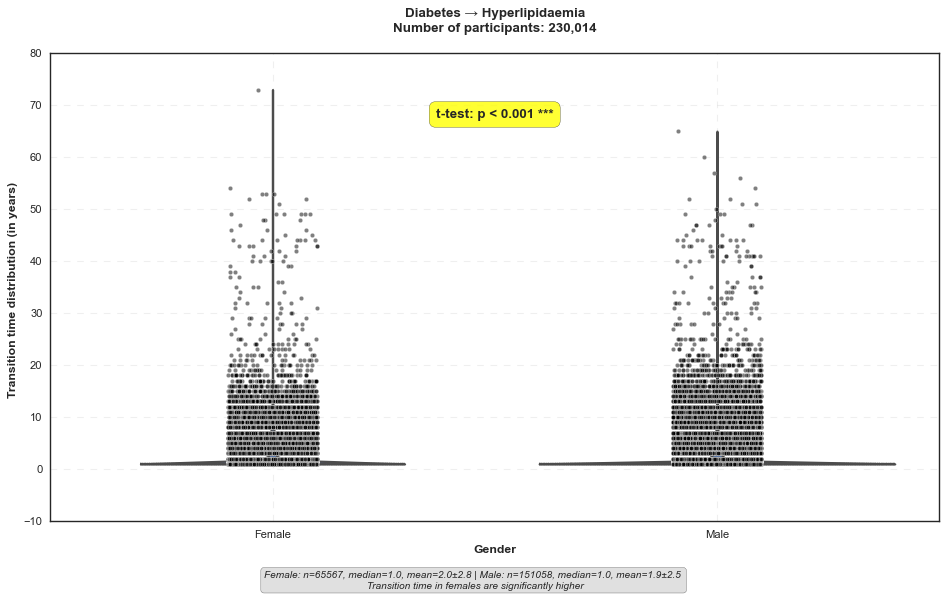

Saved: results/diabetes_Hypertension_comparison.png


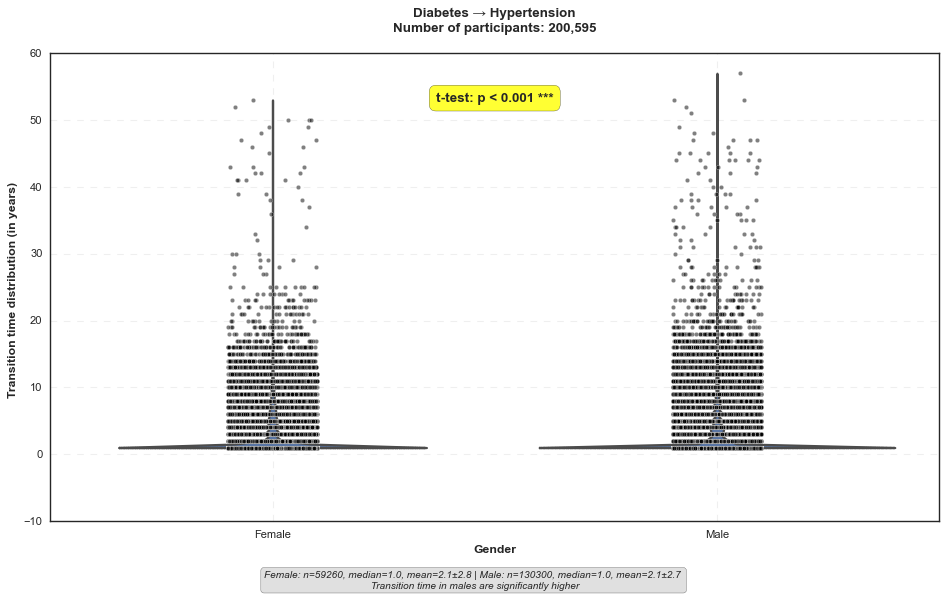

Saved: results/diabetes_Arthrosis_spondylosis_comparison.png


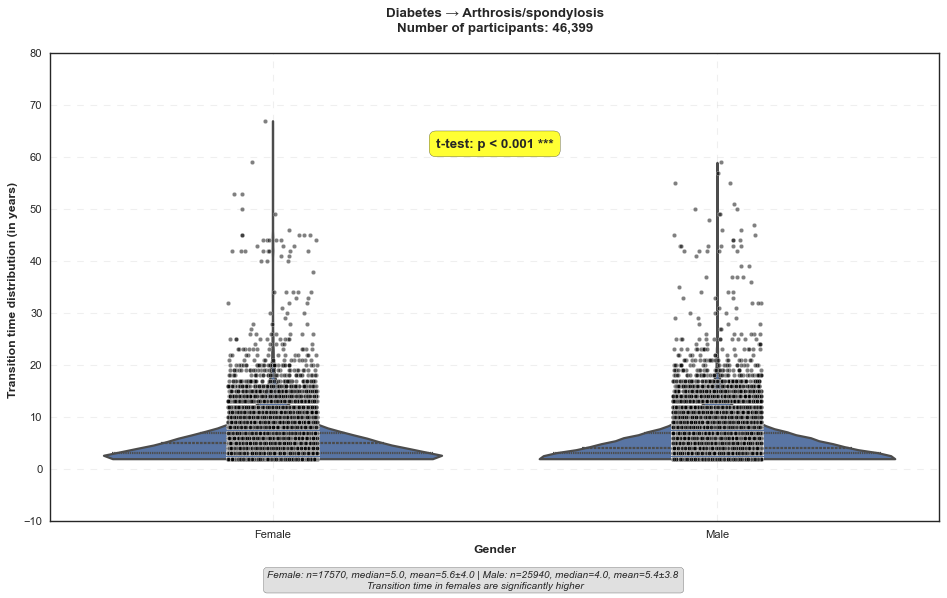

Saved: results/diabetes_Anxiety_disorder_comparison.png


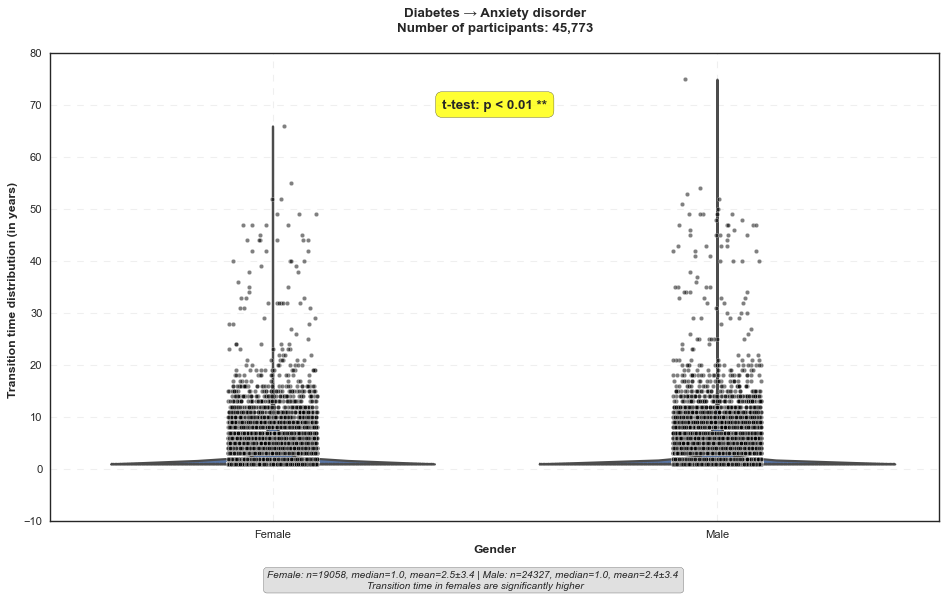

Saved: results/diabetes_Obesity_comparison.png


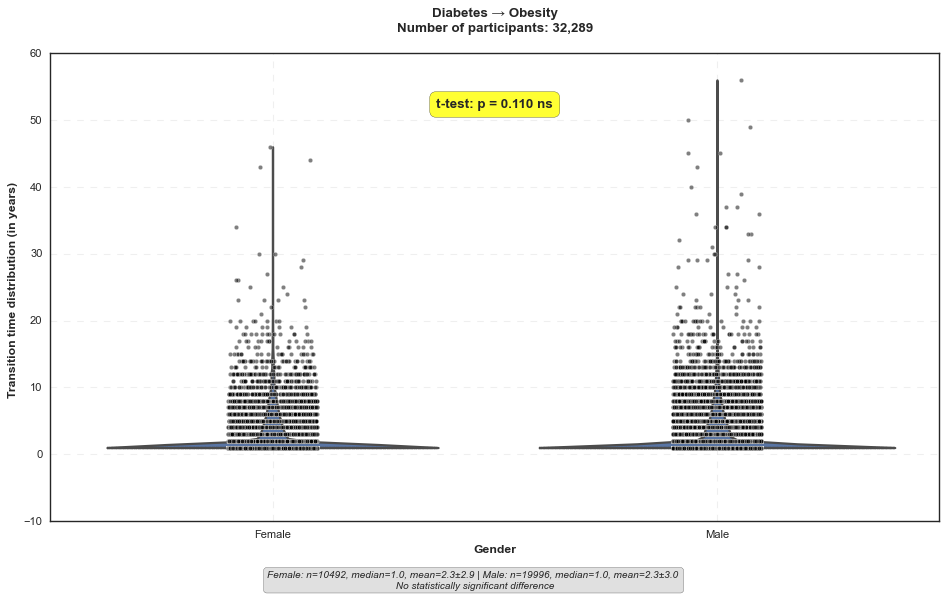

Saved: results/diabetes_Ischemic_heart_disease_comparison.png


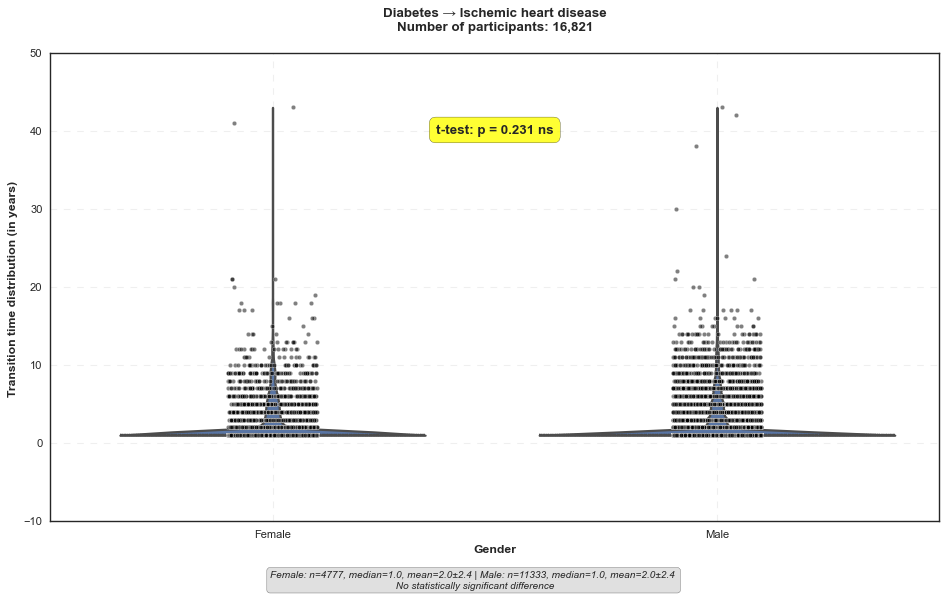

Saved: results/diabetes_Atrial_fibrillation_comparison.png


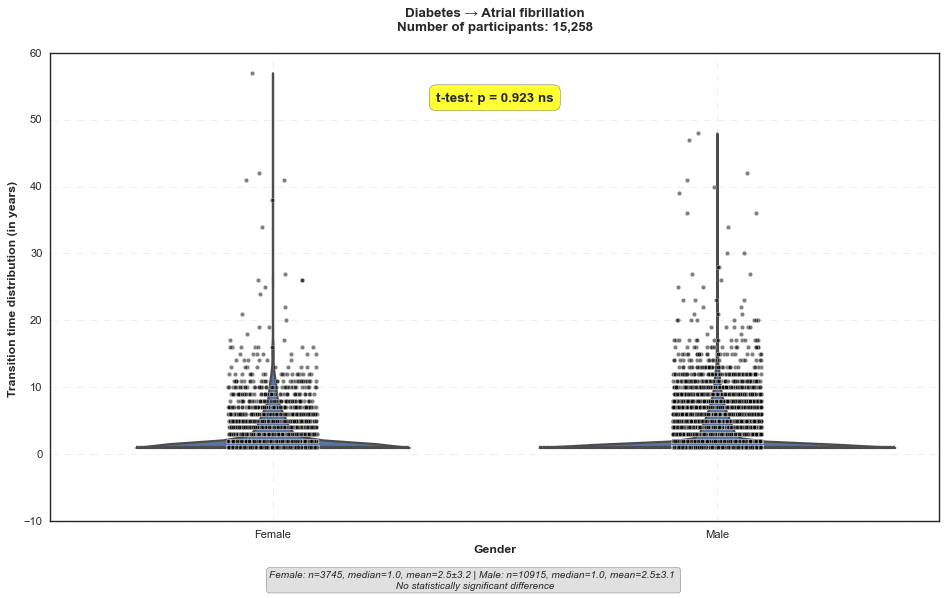

Saved: results/diabetes_Heart_failure_comparison.png


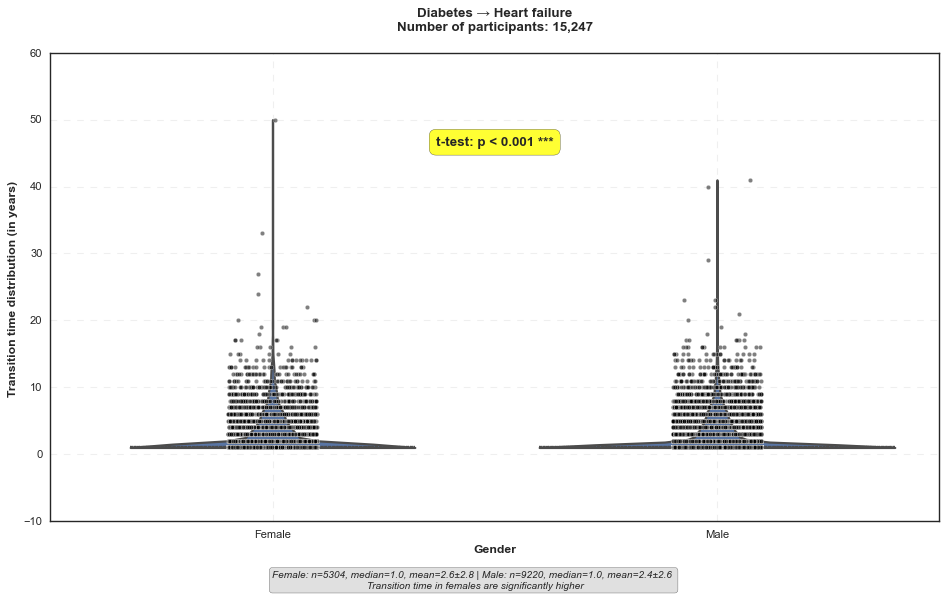

Saved: results/diabetes_Hypothyroidism_comparison.png


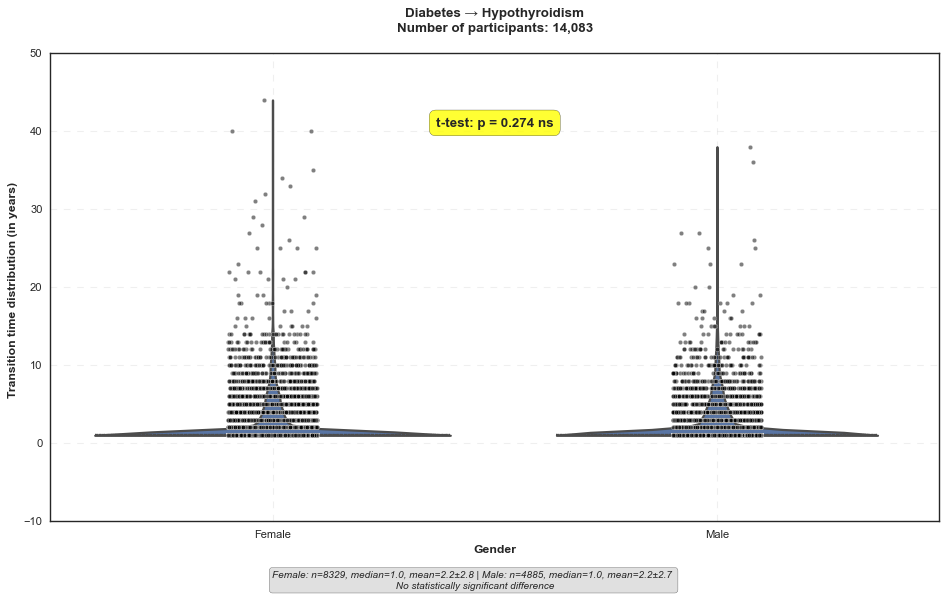

Saved: results/diabetes_Tobacco_dependence_comparison.png


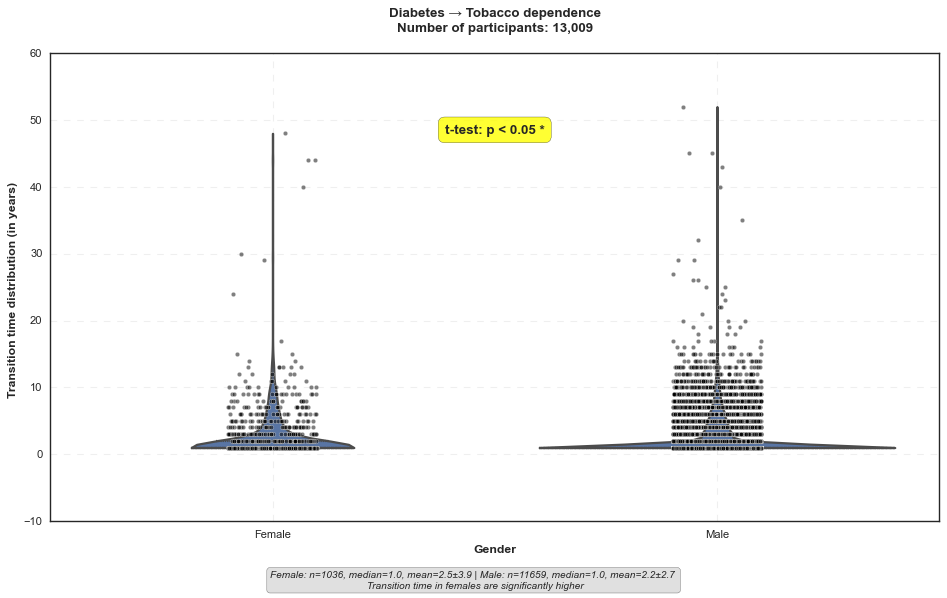

Saved: results/diabetes_COPD_comparison.png


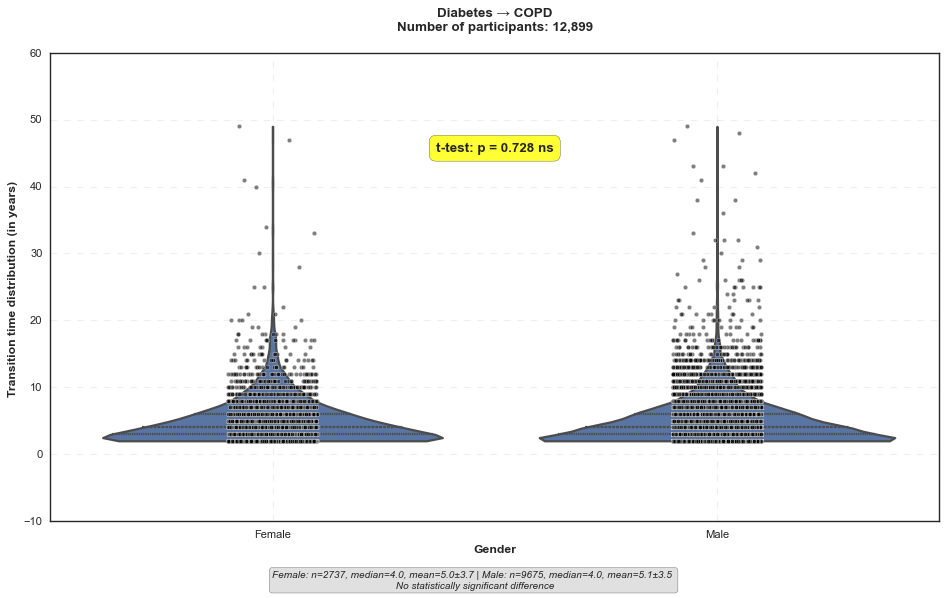

Saved: results/diabetes_Retinopathy_comparison.png


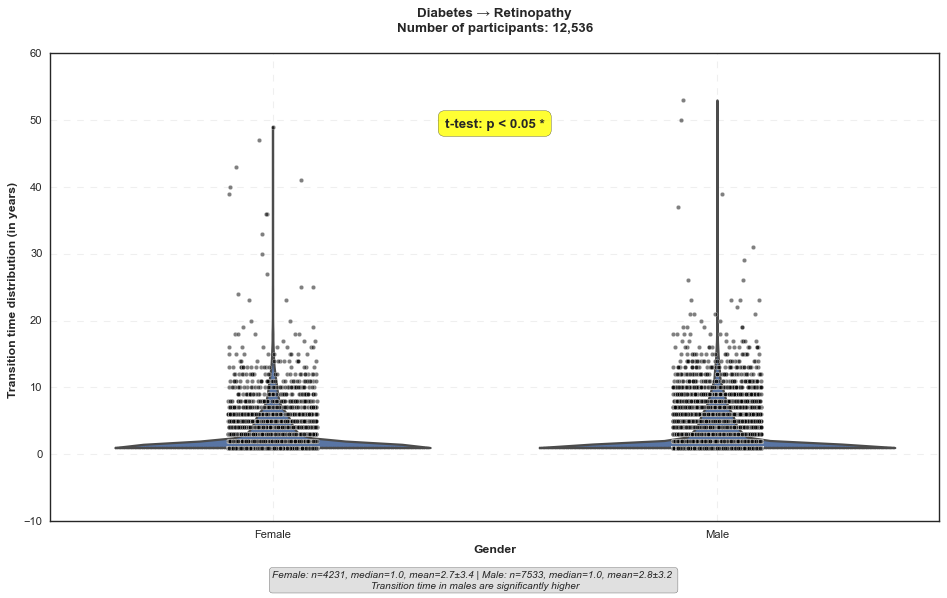

Saved: results/diabetes_Mood_disorder_comparison.png


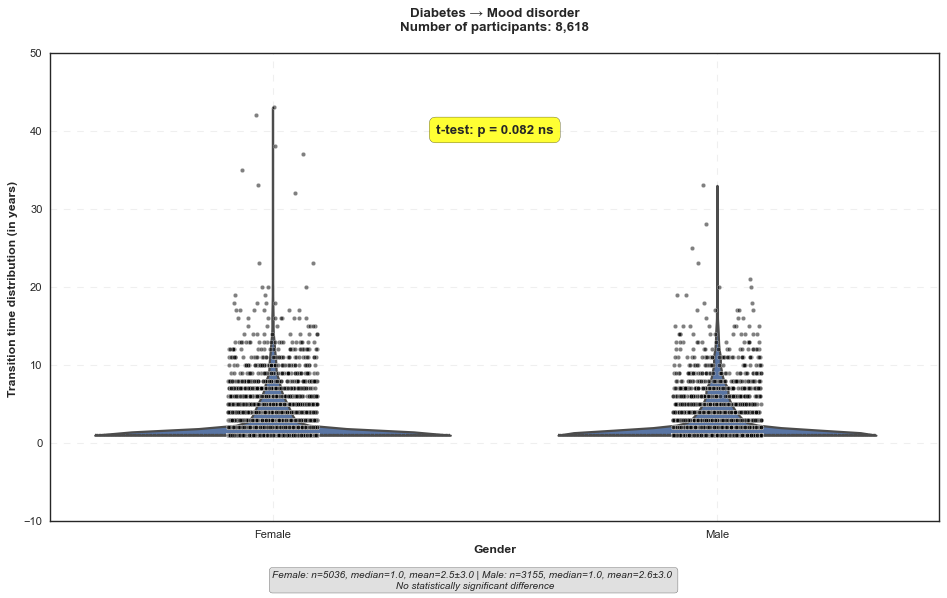

Saved: results/diabetes_Glaucoma_comparison.png


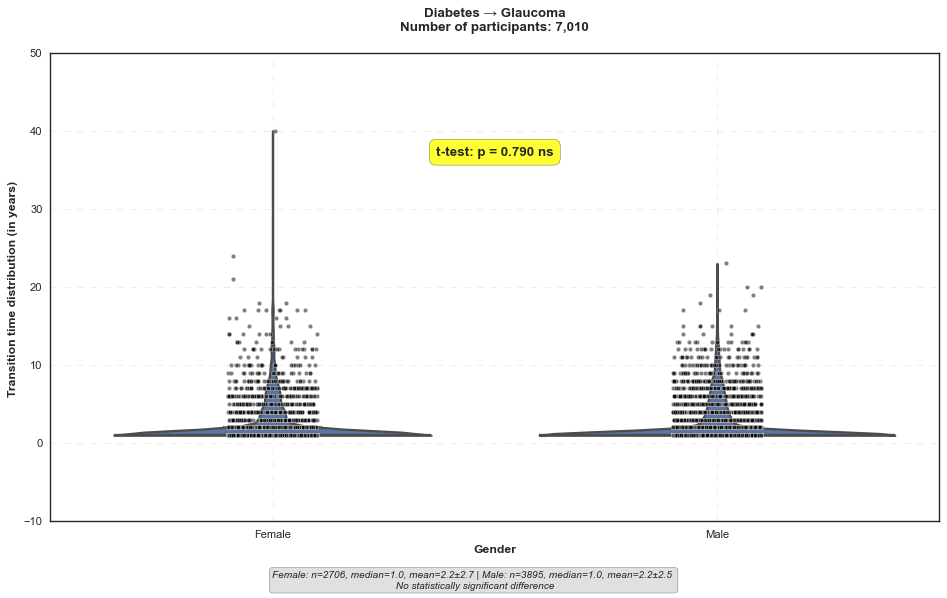

Saved: results/diabetes_Chronic_kidney_disease_comparison.png


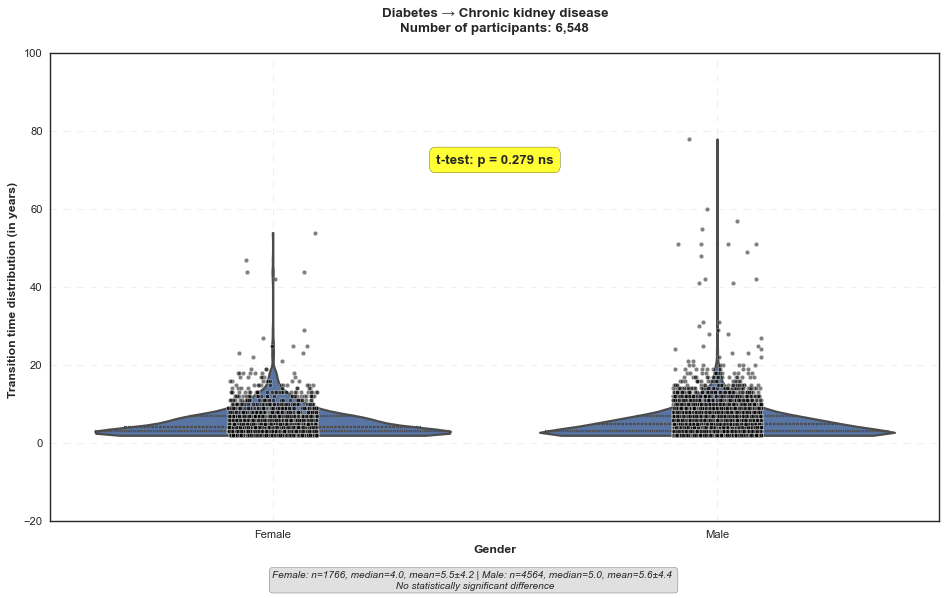

Saved: results/diabetes_Extremity_arteriopathy_diseases_comparison.png


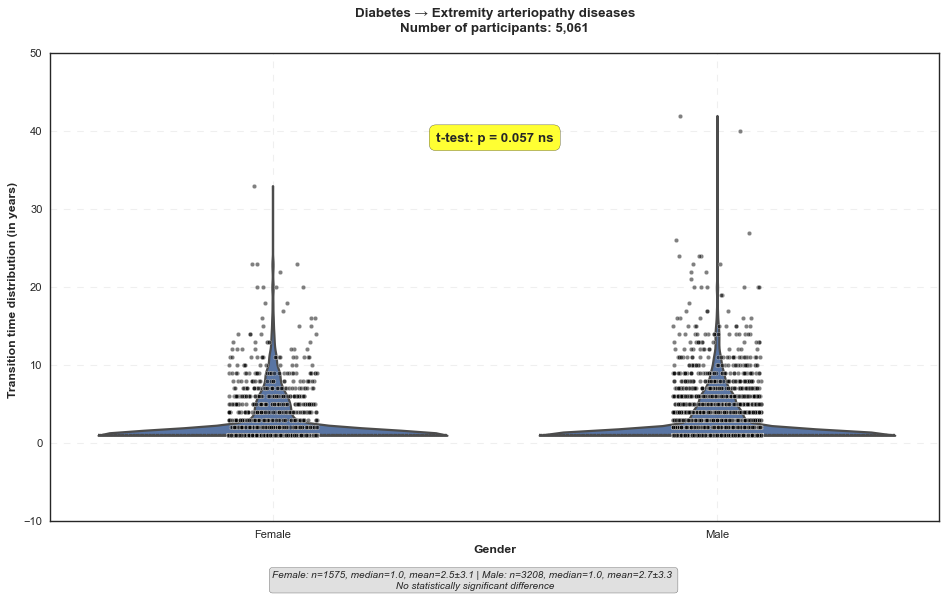

Saved: results/diabetes_Motor_disorders_with_no_CVA_comparison.png


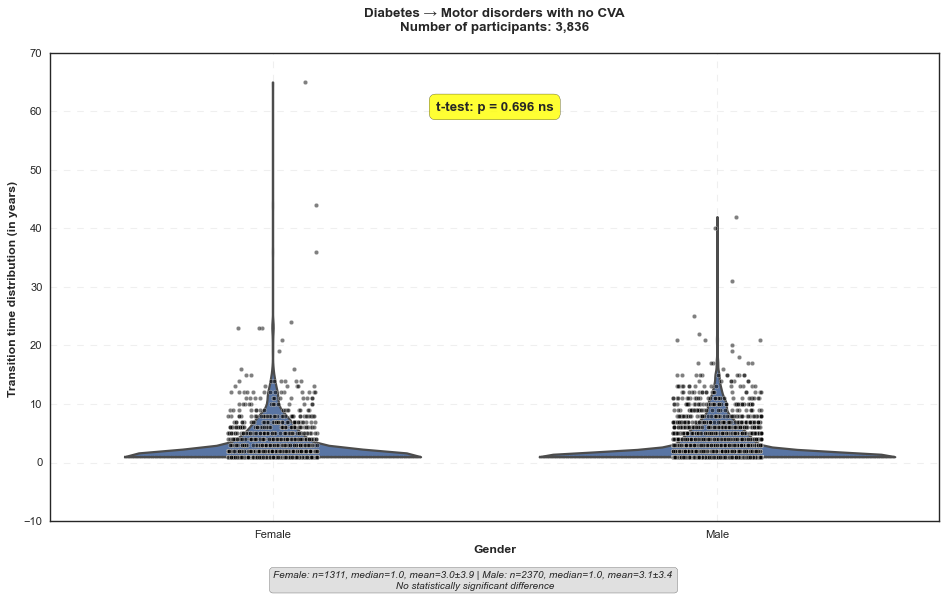

Saved: results/diabetes_Asthma_comparison.png


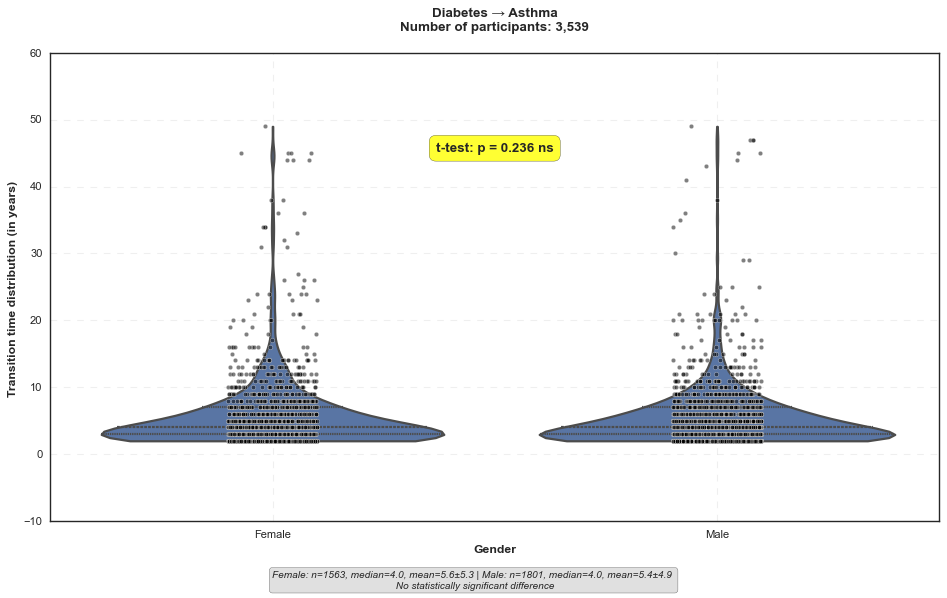

Saved: results/diabetes_Dementia_comparison.png


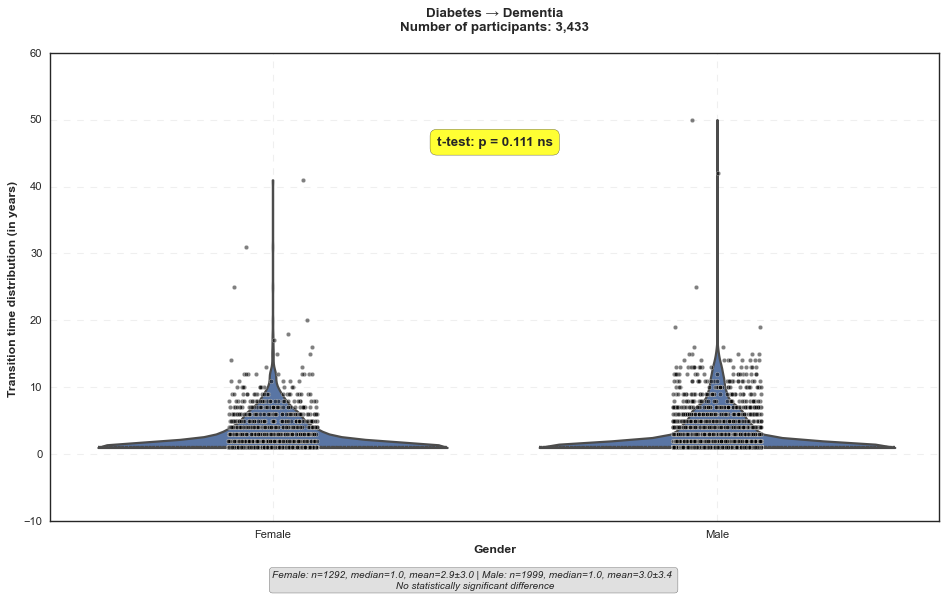

Saved: results/diabetes_Alcohol_dependence_comparison.png


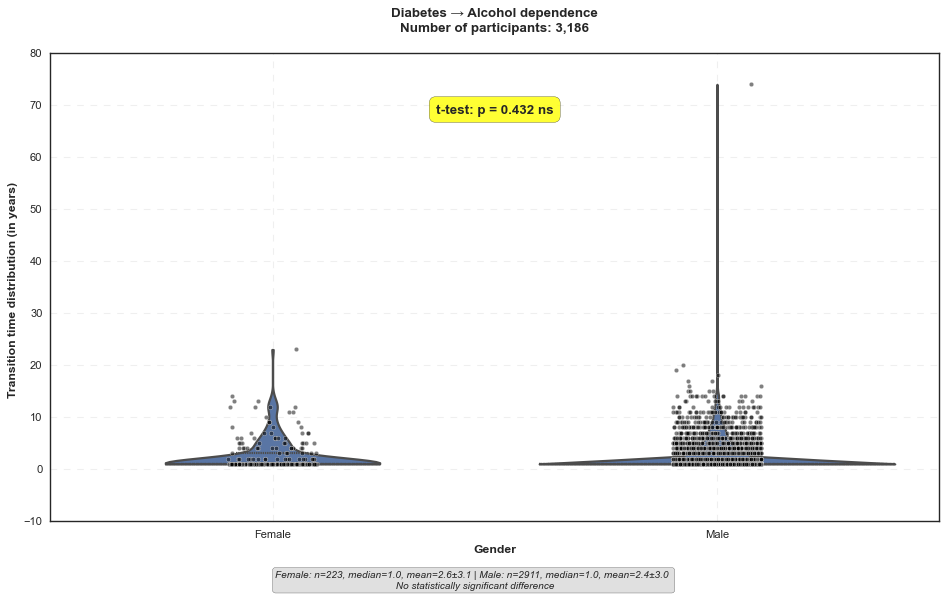

Saved: results/diabetes_Other_organic_mental_disorder_comparison.png


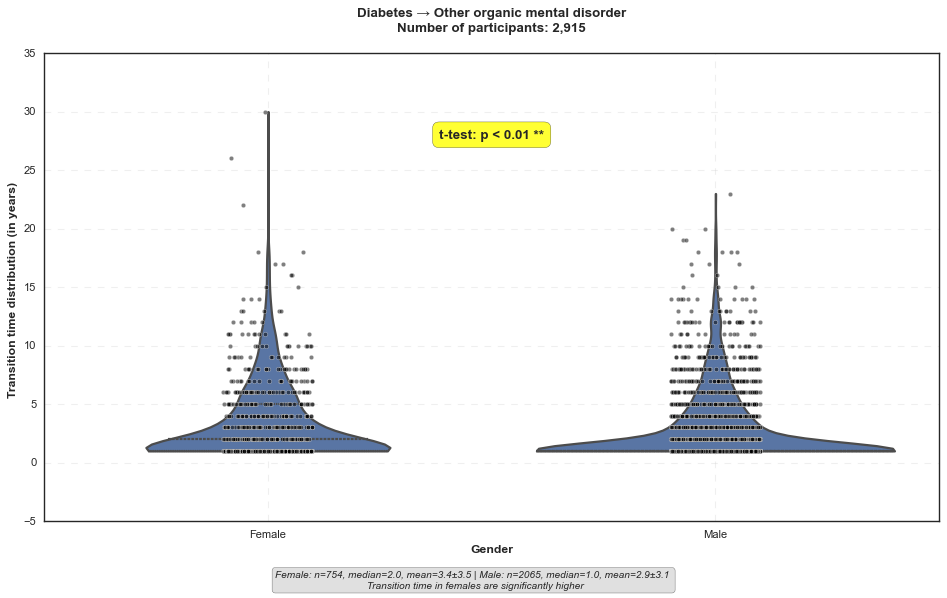

Saved: results/diabetes_Osteoporosis_comparison.png


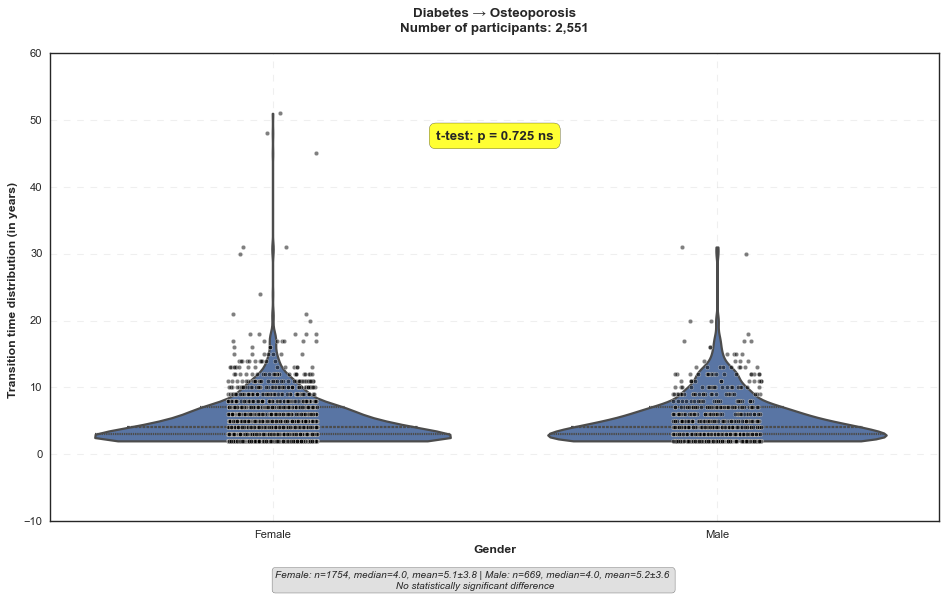

Saved: results/diabetes_Other_arthropathies_comparison.png


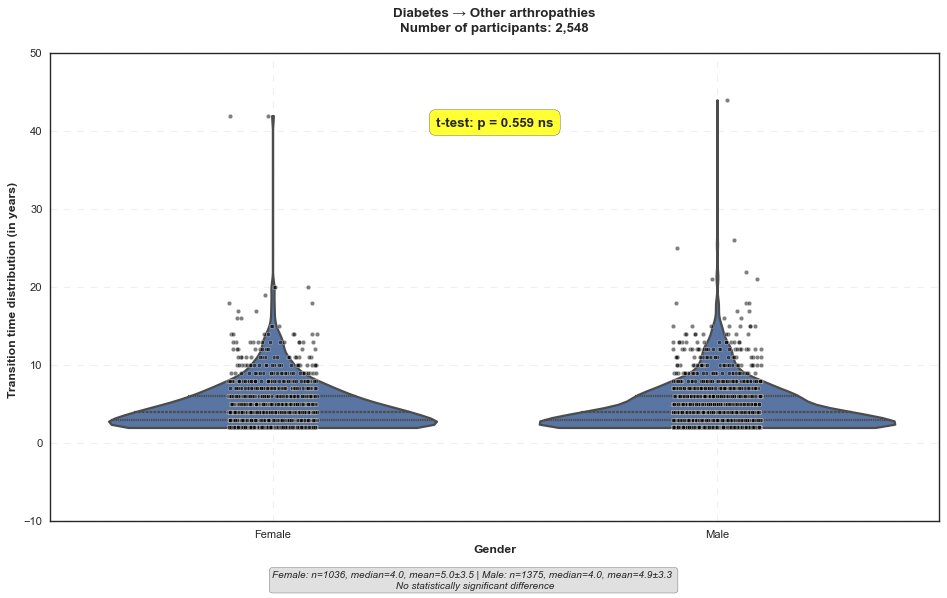

Saved: results/diabetes_Urinary_lithiasis_comparison.png


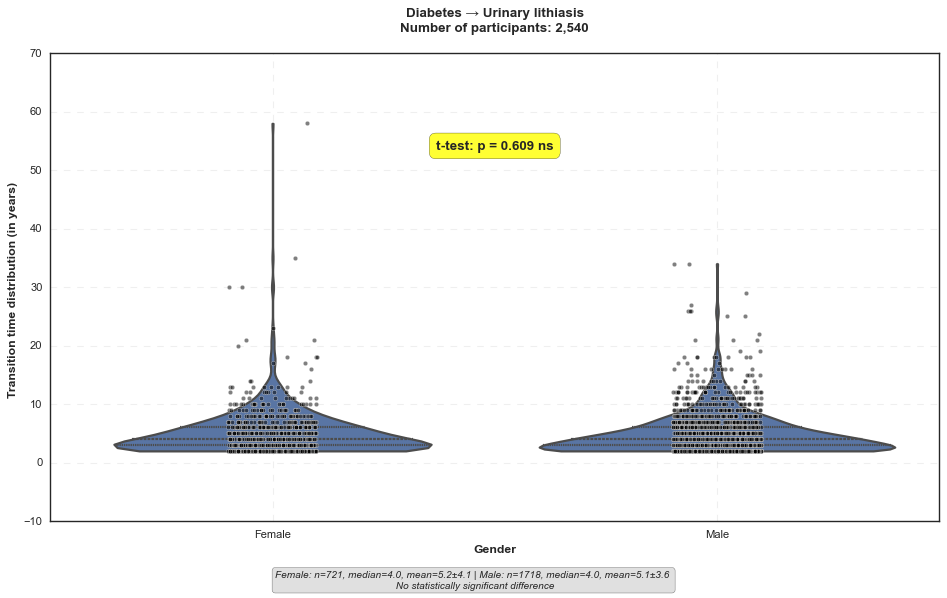

Saved: results/diabetes_Psoriasis_comparison.png


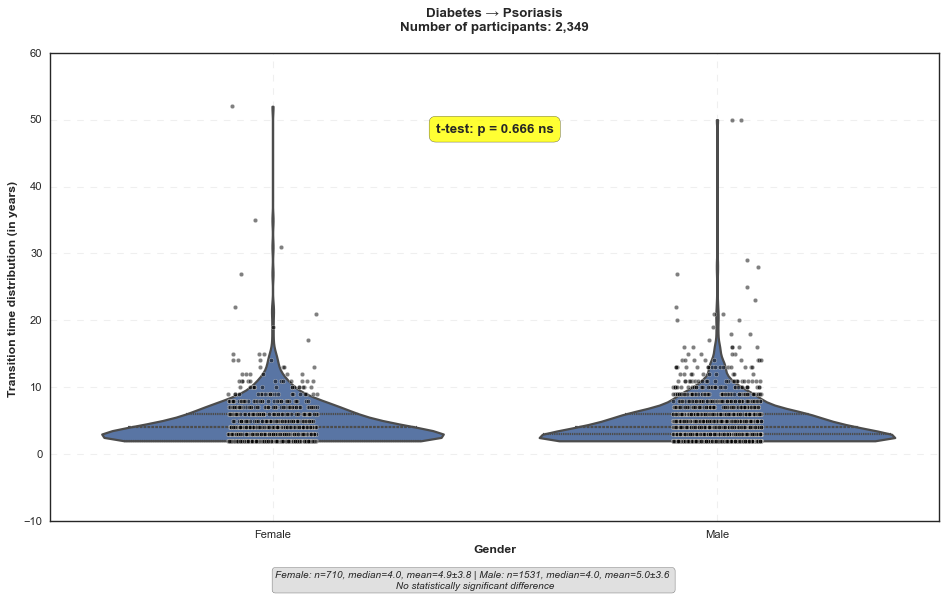

Saved: results/diabetes_Hepatic_steatosis_comparison.png


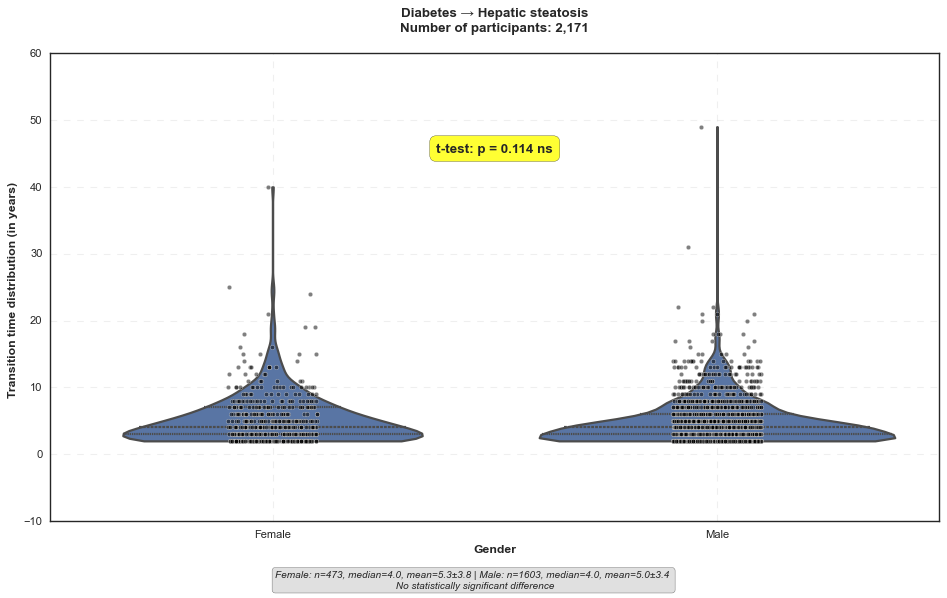

Saved: results/diabetes_Ischemic_hepatitis_except_for_cirrhosis_comparison.png


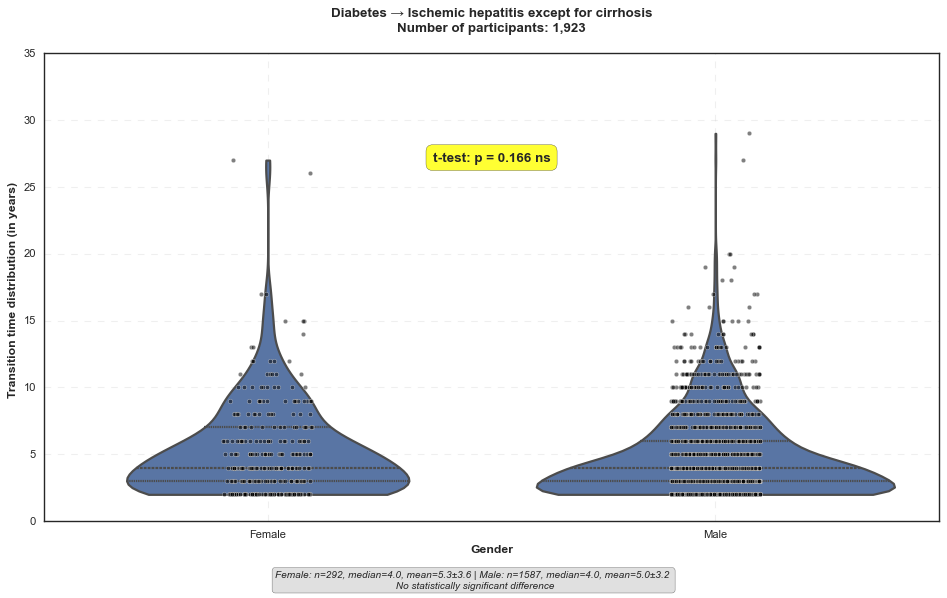

Saved: results/diabetes_Gastroesophageal_reflux_disease_comparison.png


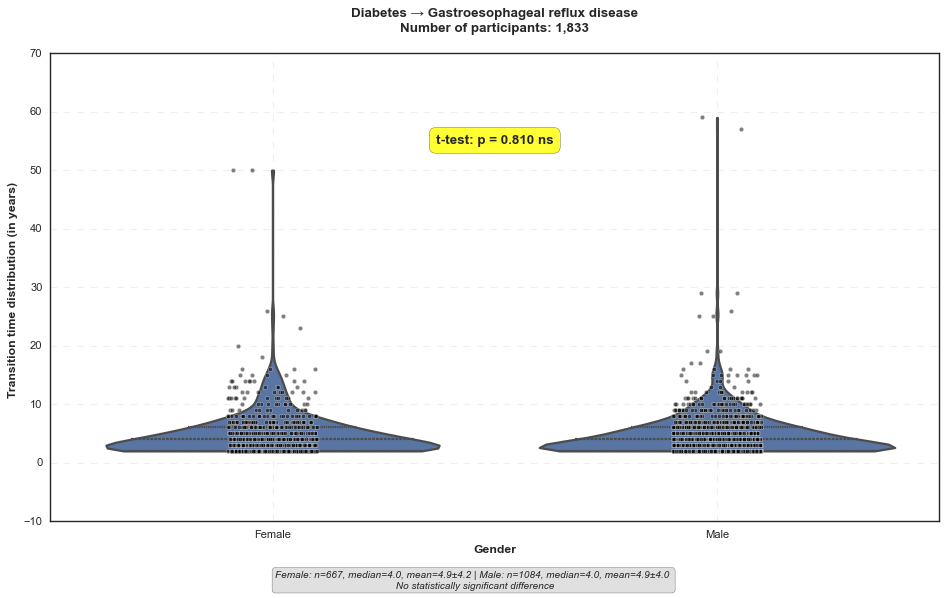

Saved: results/diabetes_Acquired_heart_diseases_comparison.png


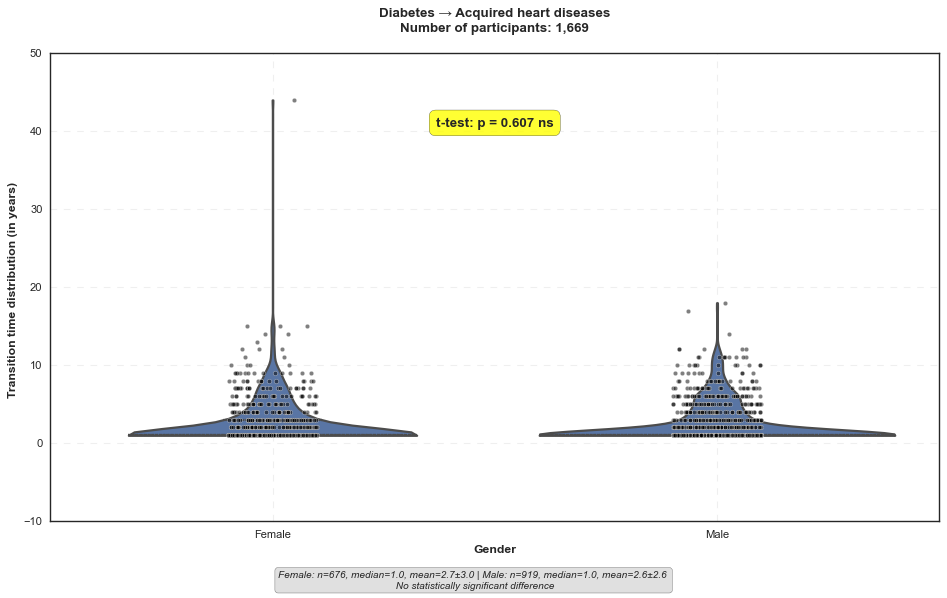

Saved: results/diabetes_Gout_and_other_crystal_deposition_diseases_comparison.png


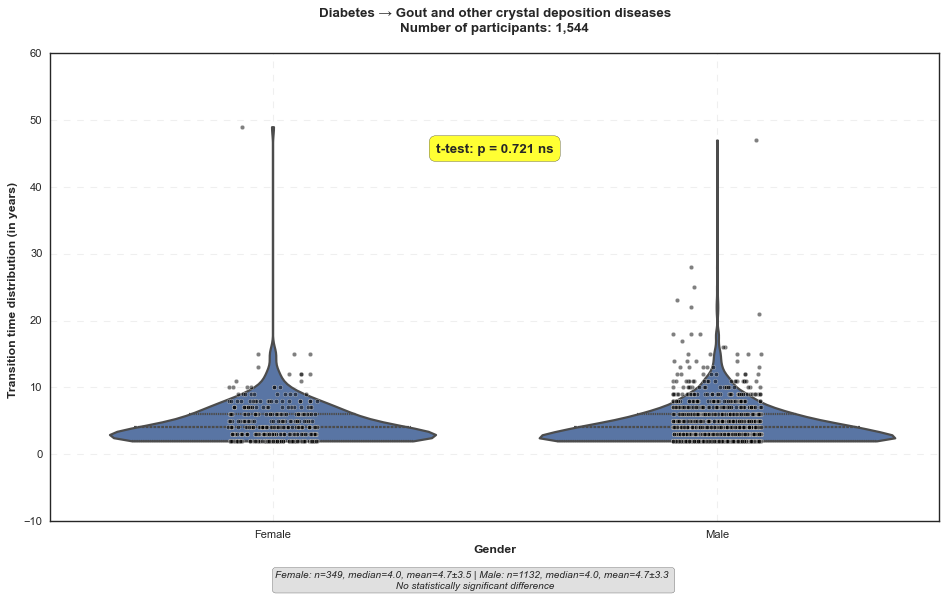

Saved: results/diabetes_Age-related_macular_degeneration_comparison.png


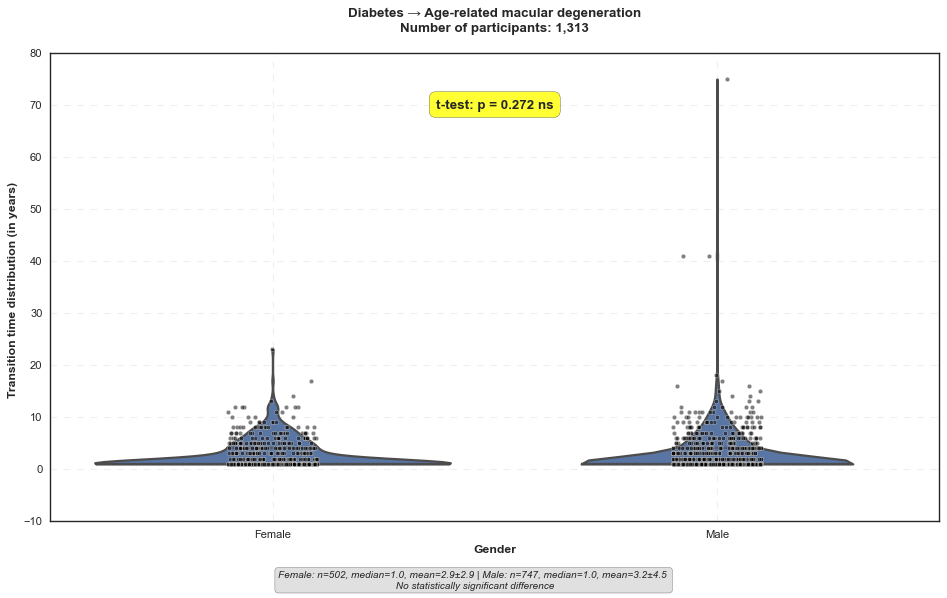

Saved: results/diabetes_Schizophrenia_comparison.png


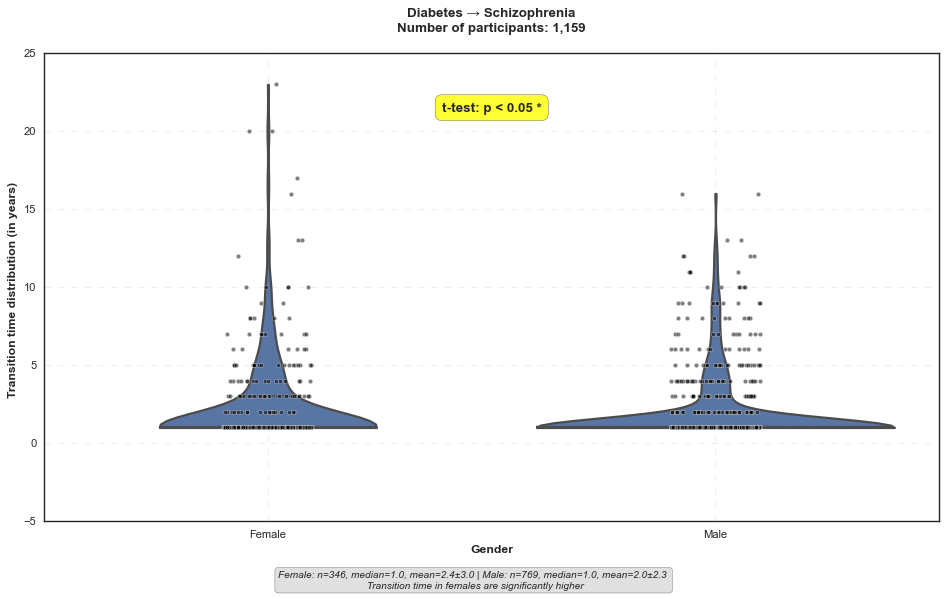

In [59]:
from scipy import stats
valid_styles = ['seaborn-v0_8-white']
palettes = ["tab10"]

for i, (idx, row) in enumerate(df.iterrows()):
    style_to_use = valid_styles[i % len(valid_styles)]
    plt.style.use(style_to_use)
    current_palette = palettes[i % len(palettes)]
    sns.set_palette(current_palette)
    female_data = row['rel.female_raw_data']
    male_data = row['rel.male_raw_data']
    
    plot_data = pd.DataFrame({'Frequency': female_data + male_data, 'Gender': ['Female'] * len(female_data) + ['Male'] * len(male_data)})
    
    t_stat, p_value = stats.ttest_ind(female_data, male_data, equal_var=False)
    plt.figure(figsize=(12, 8))
    sns.violinplot(data=plot_data, x='Gender', y='Frequency', cut=0, inner='quartile', linewidth=2)
    sns.stripplot(data=plot_data, x='Gender', y='Frequency', color='black', alpha=0.5, size=4, jitter=True, edgecolor='white', linewidth=0.5)
    plt.title(f"Diabetes → {row['complication.name']}\n"
              f"Number of participants: {row['rel.overall_frequency']:,}",
              fontweight='bold', pad=20, fontsize=12)
    
    plt.ylabel('Transition time distribution (in years) ', fontweight='bold')
    plt.xlabel('Gender', fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Calculate statistics
    female_median = np.median(female_data)
    male_median = np.median(male_data)
    female_mean = np.mean(female_data)
    male_mean = np.mean(male_data)
    female_std = np.std(female_data)
    male_std = np.std(male_data)
    
    female_stats = f"Female: n={len(female_data)}, median={female_median:.1f}, mean={female_mean:.1f}±{female_std:.1f}"
    male_stats = f"Male: n={len(male_data)}, median={male_median:.1f}, mean={male_mean:.1f}±{male_std:.1f}"
    
    # Add p-value annotation on the plot
    y_max = max(max(female_data), max(male_data))
    y_min = min(min(female_data), min(male_data))
    y_range = y_max - y_min
    
    # Determine significance level
    if p_value < 0.001:
        p_text = "p < 0.001"
        significance = "***"
    elif p_value < 0.01:
        p_text = "p < 0.01"
        significance = "**"
    elif p_value < 0.05:
        p_text = "p < 0.05"
        significance = "*"
    else:
        p_text = f"p = {p_value:.3f}"
        significance = "ns"
    
    # Add p-value text box on the plot
    plt.text(0.5, y_max - 0.05 * y_range, 
             f"t-test: {p_text} {significance}", 
             ha='center', va='top', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="yellow", alpha=0.8))
    
    if p_value < 0.05:
        if female_mean > male_mean:
            plt.figtext(0.5, 0.02, f"{female_stats} | {male_stats} \n Transition time in females are significantly higher", ha='center', fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
        else:
            plt.figtext(0.5, 0.02, f"{female_stats} | {male_stats} \n Transition time in males are significantly higher", ha='center', fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
    else:
        plt.figtext(0.5, 0.02, f"{female_stats} | {male_stats} \n No statistically significant difference", ha='center', fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))

    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    complication_name = row['complication.name'].replace('/', '_').replace(' ', '_')
    filename = f"{output_dir}/diabetes_{complication_name}_comparison.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")
    plt.show()